# Sales Data Analysis 

## Assignment

Please answer the questions below based on the data provided:

1. Plot daily sales for all 50 weeks.

2. It looks like there has been a sudden change in daily sales. What date did it occur?

3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

5. Assume a given day is divided into four dayparts:

- night (12:00AM - 6:00AM),
- morning (6:00AM - 12:00PM),
- afternoon (12:00PM - 6:00PM),
- evening (6:00PM - 12:00AM).<br> What is the percentage of sales in each daypart over all 50 weeks?

## Data Description

The datasets/ directory contains fifty CSV files (one per week) of timestamped sales data. Each row in a file has two columns:

- `sale_time` - The timestamp on which the sale was made e.g. 2012-10-01 01:42:22
- `purchaser_gender` - The gender of the person who purchased (male or female)

In [3]:
import pandas as pd
import glob
import os

# step 1 : get and sort all file paths
folder_path = '/Users/rosiebai/Downloads/datasets-9/'
file_pattern = folder_path + 'sales_week_starting_*.csv'
file_list = sorted(glob.glob(file_pattern))

# step 2: read and concatenate all CSVs, add "week_start" column from filename 

all_weeks_df = pd.concat([
    pd.read_csv(file).assign(week_start = os.path.basename(file)[20:30])
    for file in file_list
])
all_weeks_df.head()

,sale_time,purchaser_gender,week_start
0,2012-10-01 01:42:22,female,2012-10-01
1,2012-10-01 02:24:53,female,2012-10-01
2,2012-10-01 02:25:40,female,2012-10-01
3,2012-10-01 02:30:42,female,2012-10-01
4,2012-10-01 02:51:32,male,2012-10-01


In [4]:
all_weeks_df['sale_date'] = pd.to_datetime(all_weeks_df['sale_time']).dt.date

In [5]:
all_weeks_df.head()

,sale_time,purchaser_gender,week_start,sale_date
0,2012-10-01 01:42:22,female,2012-10-01,2012-10-01
1,2012-10-01 02:24:53,female,2012-10-01,2012-10-01
2,2012-10-01 02:25:40,female,2012-10-01,2012-10-01
3,2012-10-01 02:30:42,female,2012-10-01,2012-10-01
4,2012-10-01 02:51:32,male,2012-10-01,2012-10-01


In [6]:
daily_sales = all_weeks_df.groupby('sale_date')['purchaser_gender'].count().reset_index(name = 'n_sales').sort_values(by ='sale_date')


### Plot the sales data over 50 weeks

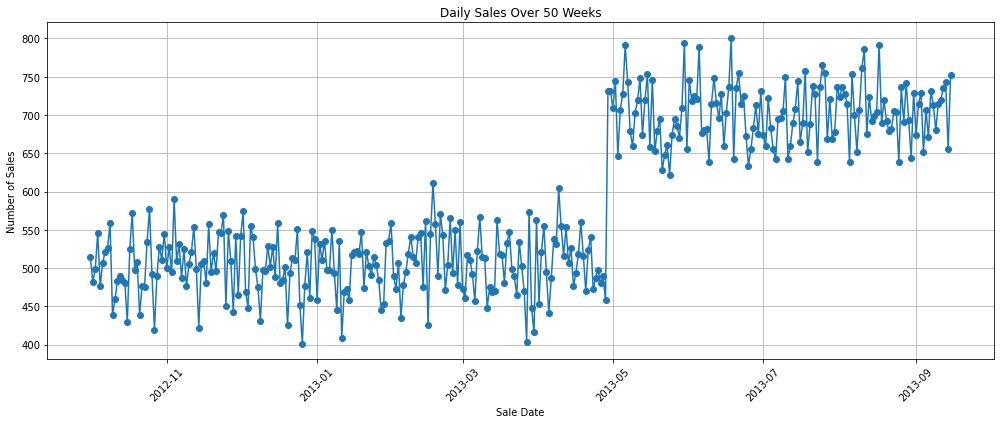

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(daily_sales['sale_date'].to_numpy(), daily_sales['n_sales'].to_numpy(), 
         marker='o', linestyle='-')
plt.title('Daily Sales Over 50 Weeks')
plt.xlabel('Sale Date')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


It looks like there has been a sudden change around 2013 May.

### Identify the cut off date for the sudden change

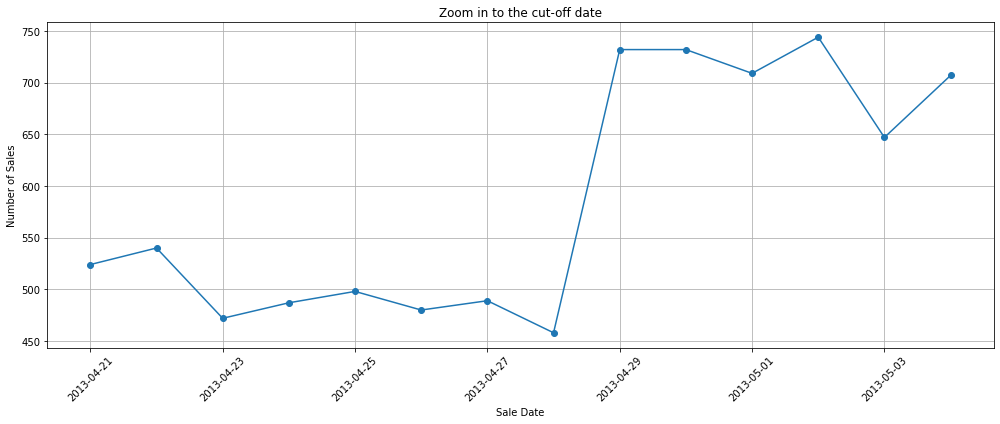

In [8]:
daily_sales['sale_date'] = pd.to_datetime(daily_sales['sale_date'])

subset = daily_sales[
    (daily_sales['sale_date'] > '2013-04-20') &
    (daily_sales['sale_date'] < '2013-05-05')
]

plt.figure(figsize=(14, 6))
plt.plot(subset['sale_date'].to_numpy(), subset['n_sales'].to_numpy(), 
         marker='o', linestyle='-')
plt.title('Zoom in to the cut-off date')
plt.xlabel('Sale Date')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Slip the data by cut off date and then use statistical test to compare means before and after

In [9]:
from scipy.stats import ttest_ind

cutoff_date = pd.to_datetime('2013-04-29')
before = daily_sales[daily_sales['sale_date'] < cutoff_date]['n_sales']
after = daily_sales[daily_sales['sale_date'] >= cutoff_date]['n_sales']

t_stat, p_value = ttest_ind(before, after, equal_var=False)

print(f'T-statistic: {t_stat:.2f}, p-value: {p_value:.4f}')


T-statistic: -45.94, p-value: 0.0000


### Verify the change is due to gender ratio

In [18]:
# get the gender ratio for daily sales
gender_daily_counts = all_weeks_df.groupby(['sale_date', 'purchaser_gender']).size().reset_index(name = 'n_sales').sort_values(by ='sale_date')
gender_pivot = gender_daily_counts.pivot(index = 'sale_date', columns = 'purchaser_gender', values = 'n_sales').fillna(0)
gender_pivot['gender_ratio'] = gender_pivot['female']/gender_pivot['male']
gender_pivot
gender_pivot['total'] = gender_pivot.sum(axis=1)
gender_pivot['pct_male'] = gender_pivot['male'] / gender_pivot['total']
gender_pivot['pct_female'] = gender_pivot['female'] / gender_pivot['total']


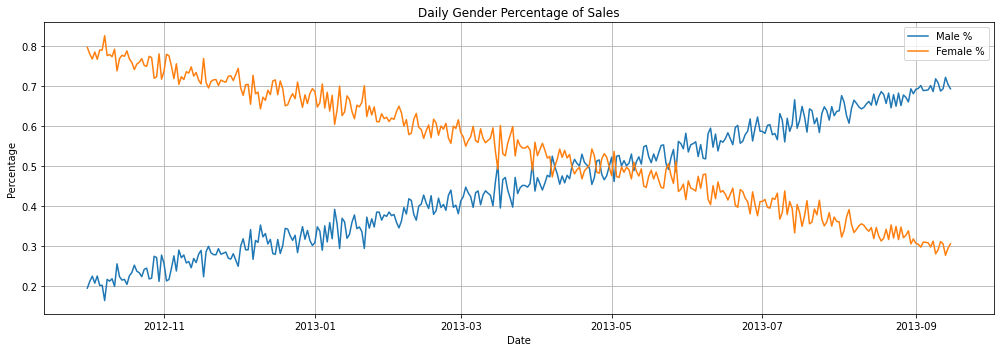

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(gender_pivot.index.to_numpy(), gender_pivot['pct_male'].to_numpy(), label='Male %')
plt.plot(gender_pivot.index.to_numpy(), gender_pivot['pct_female'].to_numpy(), label='Female %')
plt.title('Daily Gender Percentage of Sales')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Yes, data suggests that the change in daily sales is due to a shift in the proportion of male-vs-female customers.

### Dayparts analysis

In [25]:
all_weeks_df['sale_time'] = pd.to_datetime(all_weeks_df['sale_time'])
all_weeks_df['hour'] = all_weeks_df['sale_time'].dt.hour
def assign_daypart(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning' 
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'
all_weeks_df['daypart'] = all_weeks_df['hour'].apply(assign_daypart)

In [33]:
daypart_sales = all_weeks_df.groupby(['sale_date','daypart']).size().reset_index(name = 'n_sales')

In [34]:
daypart_sales.head()

,sale_date,daypart,n_sales
0,2012-10-01,afternoon,202
1,2012-10-01,evening,113
2,2012-10-01,morning,155
3,2012-10-01,night,44
4,2012-10-02,afternoon,202


In [35]:
daypart_pivot = daypart_sales.pivot(index = 'sale_date', 
                                    columns = 'daypart',
                                    values = 'n_sales'
                                    ).fillna(0)
daypart_pivot

daypart,afternoon,evening,morning,night
sale_date,,,,
2012-10-01,202,113,155,44
2012-10-02,202,98,136,46
2012-10-03,179,108,170,42
2012-10-04,214,122,164,46
2012-10-05,181,86,156,53
...,...,...,...,...
2013-09-11,281,164,212,62
2013-09-12,294,162,212,67
2013-09-13,274,165,246,58


In [36]:
daypart_pivot['total'] = daypart_pivot.sum(axis=1)
daypart_pivot['pct_afternoon'] = daypart_pivot['afternoon']/daypart_pivot['total']
daypart_pivot['pct_evening'] = daypart_pivot['evening']/daypart_pivot['total']
daypart_pivot['pct_night'] = daypart_pivot['night']/daypart_pivot['total']
daypart_pivot['pct_morning'] = daypart_pivot['morning']/daypart_pivot['total']


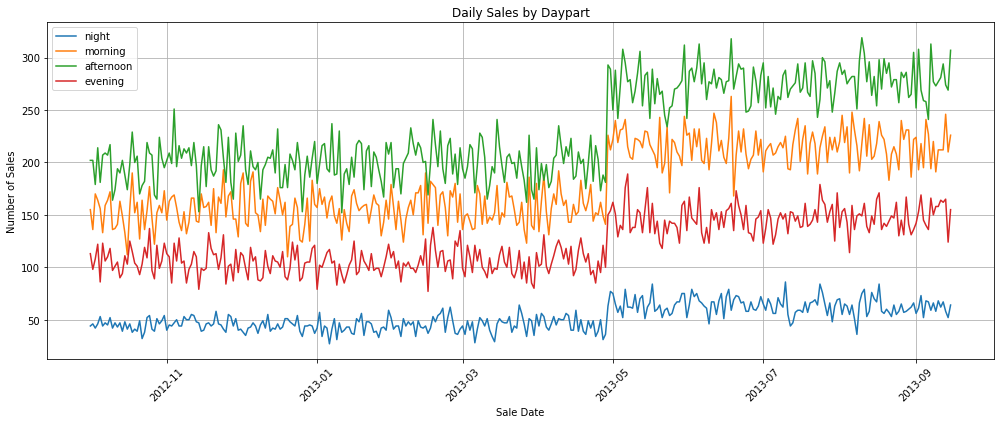

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for part in ['night', 'morning', 'afternoon', 'evening']:
    plt.plot(daypart_pivot.index.to_numpy(), daypart_pivot[part].to_numpy(), label=part)

plt.title('Daily Sales by Daypart')
plt.xlabel('Sale Date')
plt.ylabel('Number of Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


It looks like afternoons drive the sales over the 50 weeks.